In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
from PIL import Image
from io import BytesIO
from six.moves import urllib
from tensorflow.keras.applications import inception_v3, InceptionV3
tf.__version__

'2.1.0'

## Inception V3 architecture to predict ImageNet classes

see 

- https://github.com/tensorflow/models/tree/master/research/inception
- https://medium.com/@utsumuki_neko/using-inception-v3-from-tensorflow-hub-for-transfer-learning-a931ff884526


In [3]:
model = InceptionV3(weights='imagenet', include_top=True)

In [4]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
k = model.get_layer("input_1")
k.input

<tf.Tensor 'input_1:0' shape=(None, 299, 299, 3) dtype=float32>

In [6]:
k = model.get_weights()

(144, 150, 3)


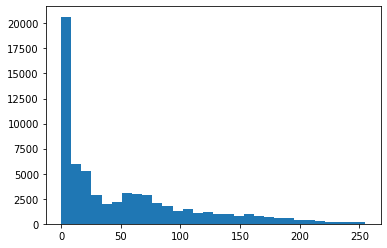

In [27]:
from skimage.transform import resize
img = plt.imread("local/imgs/french-horn.jpg")
print (img.shape)
plt.hist(img.flatten(),bins=30);

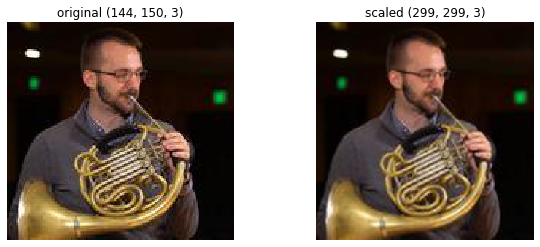

In [28]:
aimg = resize(img, output_shape=(299,299,3))
plt.figure(figsize=(10,4))
plt.subplot(121); plt.imshow(img); plt.title("original %s"%str(img.shape)); plt.axis("off");
plt.subplot(122); plt.imshow(aimg); plt.title("scaled %s"%str(aimg.shape)); plt.axis("off");


### predict and decode

observe that image pixels values **MUST $\in [-,1,1]$**, so we rescale them

(1, 1000)

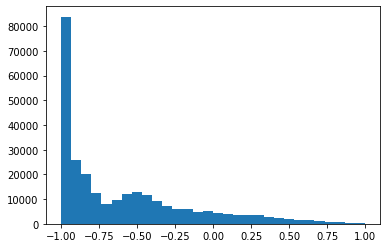

In [40]:
plt.hist(aimg.flatten()*2-1, bins=30);
pred = model.predict(aimg.reshape(-1,*aimg.shape)*2-1)
pred.shape

In [41]:
pred[0]

array([8.14844407e-06, 4.02417845e-06, 1.20561808e-05, 1.14837749e-05,
       6.06919866e-06, 3.07554001e-05, 2.90424978e-05, 3.65194364e-06,
       1.29718974e-05, 2.19100330e-05, 1.37086798e-04, 6.11870746e-06,
       2.08850979e-05, 5.15535839e-06, 4.47761795e-06, 1.00888801e-05,
       4.37572999e-06, 3.90674404e-06, 2.60138813e-06, 6.77022217e-06,
       2.14100819e-05, 3.89699107e-06, 1.09444845e-05, 1.38123714e-05,
       5.99189752e-06, 5.34122091e-06, 1.72298369e-05, 2.85072874e-05,
       2.18836794e-05, 1.57219292e-05, 2.13245767e-05, 5.44572003e-06,
       1.33835792e-05, 1.82441217e-05, 1.62383931e-05, 1.83049651e-05,
       2.13665735e-05, 1.81970336e-05, 1.29576902e-05, 6.59011994e-06,
       4.24499376e-05, 6.28004564e-05, 1.10803303e-05, 1.86357411e-05,
       2.17489214e-05, 1.67862254e-05, 3.14121644e-05, 1.70080530e-05,
       1.57654104e-05, 6.68654911e-06, 1.59955162e-05, 1.36291565e-05,
       5.06863626e-06, 3.10357336e-06, 3.86179090e-05, 8.66942537e-06,
      

In [42]:
print ("highest probabilities", [np.round(i,4) for i in np.sort(pred[0])[::-1][:10]])
print ("highest class codes  ", np.argsort(pred[0])[::-1][:10])

highest probabilities [0.9849, 0.0005, 0.0005, 0.0004, 0.0002, 0.0002, 1e-04, 1e-04, 1e-04, 1e-04]
highest class codes   [566 432 683 262 639 676  10  57 513  70]


In [43]:
from tensorflow.keras.applications.inception_v3 import decode_predictions

print ('Predicted:')
k = decode_predictions(pred, top=30)[0]
for i in k:
    print("%10s %20s %.6f"%i)


Predicted:
 n03394916          French_horn 0.984903
 n02804610              bassoon 0.000529
 n03838899                 oboe 0.000484
 n02112706    Brabancon_griffon 0.000361
 n03710721              maillot 0.000173
 n03803284               muzzle 0.000161
 n01530575            brambling 0.000137
 n01735189         garter_snake 0.000125
 n03110669               cornet 0.000125
 n01770081           harvestman 0.000107
 n01930112             nematode 0.000104
 n04579432              whistle 0.000100
 n04086273             revolver 0.000088
 n01770393             scorpion 0.000073
 n07831146            carbonara 0.000068
 n01685808             whiptail 0.000063
 n01739381           vine_snake 0.000057
 n04116512        rubber_eraser 0.000056
 n02106550           Rottweiler 0.000055
 n02395406                  hog 0.000054
 n02396427            wild_boar 0.000053
 n02097209   standard_schnauzer 0.000052
 n02097047  miniature_schnauzer 0.000052
 n13133613                  ear 0.000052
 n041

### occlusion affects prediction

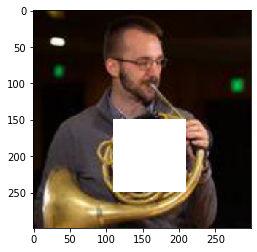

In [44]:
oimg = aimg.copy()
w,h=100,100
bx,by=110,150
oimg[by:by+h,bx:bx+w]=np.max(oimg)
p = oimg[by:by+h,bx:bx+w,:]
plt.imshow(oimg)

observe how prediction probabilities change when occlusion happens on the key object. Try also the following:

- bx=80 and by=80

what part of the instrument is more responsible for the CNN classification?

In [45]:
pred = model.predict(oimg.reshape(-1,*oimg.shape))
decode_predictions(pred, top=5)

[[('n02815834', 'beaker', 0.10617971),
  ('n03110669', 'cornet', 0.09212437),
  ('n03394916', 'French_horn', 0.07629236),
  ('n02804610', 'bassoon', 0.076237775),
  ('n04579145', 'whiskey_jug', 0.04271703)]]